In [2]:
import ee
import geemap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
import pickle
import warnings
import time
warnings.filterwarnings('ignore')
%matplotlib inline


In [3]:
# Cell 1: Authenticate and Initialize GEE
try:
    ee.Initialize()
    print("GEE initialized successfully.")
except ee.EEException as e:
    if "incompatible OAuth2 Client configuration" in str(e):
        print("""
        Error: Incompatible OAuth2 Client configuration. Please follow these steps:
        1. Go to Google Cloud Console (https://console.cloud.google.com).
        2. Verify your project has the Earth Engine API enabled (APIs & Services > Library).
        3. Check OAuth 2.0 Client ID (APIs & Services > Credentials):
           - Ensure a Web application or Desktop app client exists.
           - Add redirect URI (e.g., http://localhost:8080) if needed.
        4. Configure OAuth consent screen (APIs & Services > OAuth consent screen).
        5. Alternatively, create a new project and register it at https://signup.earthengine.google.com.
        6. Clear old tokens: Run `earthengine authenticate --clear` in terminal.
        7. Re-authenticate below.
        See https://developers.google.com/earth-engine/guides/auth#troubleshooting for details.
        """)
    print("""
    Authenticating GEE...
    1. Open the URL provided in a browser.
    2. Sign in with your GEE-registered Google account.
    3. Approve permissions to generate an authorization code.
    4. Copy the code and paste it into the input box below.
    If no input box appears, restart the kernel and re-run this cell.
    """)
    ee.Authenticate()
    try:
        ee.Initialize()
        print("GEE initialized after authentication.")
    except Exception as e2:
        print(f"Initialization failed: {e2}")
        print("Please check your Google Cloud project configuration or try a different project.")
        print("Run `earthengine authenticate --clear` in terminal to clear old tokens and retry.")

GEE initialized successfully.


In [4]:
# Cell 2: Define Region and Time Period
roi = ee.Geometry.Rectangle([26, 35, 45, 42])  # Turkey bounding box
start_date = '2019-01-01'
end_date = '2020-09-30'  # 21 months


In [5]:
# Cell 3: Fetch GEE Datasets
# Sentinel-5P: NO2, SO2, O3, CO
no2 = ee.ImageCollection('COPERNICUS/S5P/NRTI/L3_NO2').filterDate(start_date, end_date).filterBounds(roi).select('NO2_column_number_density')
so2 = ee.ImageCollection('COPERNICUS/S5P/NRTI/L3_SO2').filterDate(start_date, end_date).filterBounds(roi).select('SO2_column_number_density')
o3 = ee.ImageCollection('COPERNICUS/S5P/NRTI/L3_O3').filterDate(start_date, end_date).filterBounds(roi).select('O3_column_number_density')
co = ee.ImageCollection('COPERNICUS/S5P/NRTI/L3_CO').filterDate(start_date, end_date).filterBounds(roi).select('CO_column_number_density')
# MODIS: AOD
aod = ee.ImageCollection('MODIS/006/MCD19A2_GRANULES').filterDate(start_date, end_date).filterBounds(roi).select('Optical_Depth_047')

C:\Users\muhda\AppData\Local\Programs\Python\Python312\Lib\site-packages\ee\deprecation.py:207: DeprecationWarning: 

Attention required for MODIS/006/MCD19A2_GRANULES! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MCD19A2_GRANULES

  warnings.warn(warning, category=DeprecationWarning)


In [6]:
# Cell 4: Aggregate Data to Monthly Means
def aggregate_monthly(collection, band):
    months = ee.List.sequence(1, 21)  # Jan 2019 to Sep 2020
    def month_mean(m):
        start = ee.Date('2019-01-01').advance(ee.Number(m).subtract(1), 'month')
        end = start.advance(1, 'month')
        monthly_collection = collection.filterDate(start, end)
        # Check if collection has images
        count = monthly_collection.size()
        # Create a valid month string
        month_str = start.format('YYYY-MM')
        # If no images, create a zero-filled image with valid metadata
        mean = ee.Image(0).rename(band).set('month', month_str)
        # If images exist, compute mean and unmask with 0
        mean = mean.where(
            count.gt(0),
            monthly_collection.mean().select(band).unmask(0)
        )
        return mean.set('month', month_str)
    return ee.ImageCollection.fromImages(months.map(month_mean))

no2_monthly = aggregate_monthly(no2, 'NO2_column_number_density')
so2_monthly = aggregate_monthly(so2, 'SO2_column_number_density')
o3_monthly = aggregate_monthly(o3, 'O3_column_number_density')
co_monthly = aggregate_monthly(co, 'CO_column_number_density')
aod_monthly = aggregate_monthly(aod, 'Optical_Depth_047')

In [7]:
# Cell 5: Extract Data to Pandas DataFrame
def image_to_df(collection, band_name, scale=50000, max_attempts=3, delay=10):
    data = []
    print(f"Processing {band_name}...")
    # Log collection size for debugging
    collection_size = collection.size().getInfo()
    print(f"Collection size for {band_name}: {collection_size} images")
    for i in range(21):
        attempt = 0
        while attempt < max_attempts:
            try:
                img = ee.Image(collection.toList(21).get(i))
                # Fetch month property safely
                month = img.get('month').getInfo()
                if not month:
                    print(f"Warning: Month property missing for month {i+1} in {band_name}. Appending NaN.")
                    data.append({'month': None, band_name: np.nan})
                    break
                # Check if band exists
                bands = img.bandNames().getInfo()
                if band_name not in bands:
                    print(f"Warning: Band {band_name} not found in month {month}. Appending NaN.")
                    data.append({'month': month, band_name: np.nan})
                    break
                values = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=roi, scale=scale).get(band_name).getInfo()
                data.append({'month': month, band_name: values if values is not None else np.nan})
                print(f"Processed month {month}")
                break
            except ee.EEException as e:
                attempt += 1
                if attempt == max_attempts:
                    print(f"Error processing month {i+1} for {band_name} after {max_attempts} attempts: {e}")
                    data.append({'month': None, band_name: np.nan})
                else:
                    print(f"Retrying month {i+1} for {band_name} (attempt {attempt+1}/{max_attempts})...")
                    time.sleep(delay)
            except Exception as e:
                print(f"Unexpected error in month {i+1} for {band_name}: {e}")
                data.append({'month': None, band_name: np.nan})
                break
    df = pd.DataFrame(data)
    valid_count = df[band_name].notna().sum()
    print(f"Completed {band_name}: {valid_count}/21 months with valid data")
    return df

# Process datasets sequentially with delay to avoid quota limits
datasets = [
    (no2_monthly, 'NO2_column_number_density'),
    (so2_monthly, 'SO2_column_number_density'),
    (o3_monthly, 'O3_column_number_density'),
    (co_monthly, 'CO_column_number_density'),
    (aod_monthly, 'Optical_Depth_047')
]

dataframes = []
for collection, band_name in datasets:
    df = image_to_df(collection, band_name)
    if df.empty or df[band_name].isna().all():
        print(f"Warning: No valid data for {band_name}. Check dataset availability.")
    dataframes.append(df)
    time.sleep(2)

# Merge DataFrames
df = dataframes[0]
for df_next in dataframes[1:]:
    df = df.merge(df_next, on='month', how='outer')
df['month'] = pd.to_datetime(df['month'], errors='coerce')

# Validate merged DataFrame
if df.empty or df.drop(columns='month').isna().all().all():
    print("Error: Merged DataFrame is empty or contains only NaN values. Check GEE data availability.")
else:
    print("Merged DataFrame successfully created.")

# Save merged DataFrame
with open('gee_data.pkl', 'wb') as f:
    pickle.dump(df, f)

Processing NO2_column_number_density...
Collection size for NO2_column_number_density: 21 images
Processed month 2019-01
Processed month 2019-02
Processed month 2019-03
Processed month 2019-04
Processed month 2019-05
Processed month 2019-06
Processed month 2019-07
Processed month 2019-08
Processed month 2019-09
Processed month 2019-10
Processed month 2019-11
Processed month 2019-12
Processed month 2020-01
Processed month 2020-02
Processed month 2020-03
Processed month 2020-04
Processed month 2020-05
Processed month 2020-06
Processed month 2020-07
Processed month 2020-08
Processed month 2020-09
Completed NO2_column_number_density: 21/21 months with valid data
Processing SO2_column_number_density...
Collection size for SO2_column_number_density: 21 images
Processed month 2019-01
Processed month 2019-02
Processed month 2019-03
Processed month 2019-04
Processed month 2019-05
Processed month 2019-06
Processed month 2019-07
Processed month 2019-08
Processed month 2019-09
Processed month 2019

In [8]:
# Cell 6: EDA - Summary Statistics
print("Dataset Info:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   month                      21 non-null     datetime64[ns]
 1   NO2_column_number_density  21 non-null     float64       
 2   SO2_column_number_density  21 non-null     float64       
 3   O3_column_number_density   21 non-null     float64       
 4   CO_column_number_density   21 non-null     float64       
 5   Optical_Depth_047          21 non-null     float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 1.1 KB
None

Summary Statistics:
                     month  NO2_column_number_density  \
count                   21                  21.000000   
mean   2019-10-31 16:00:00                   0.000071   
min    2019-01-01 00:00:00                   0.000061   
25%    2019-06-01 00:00:00                   0.000067   
50%    201

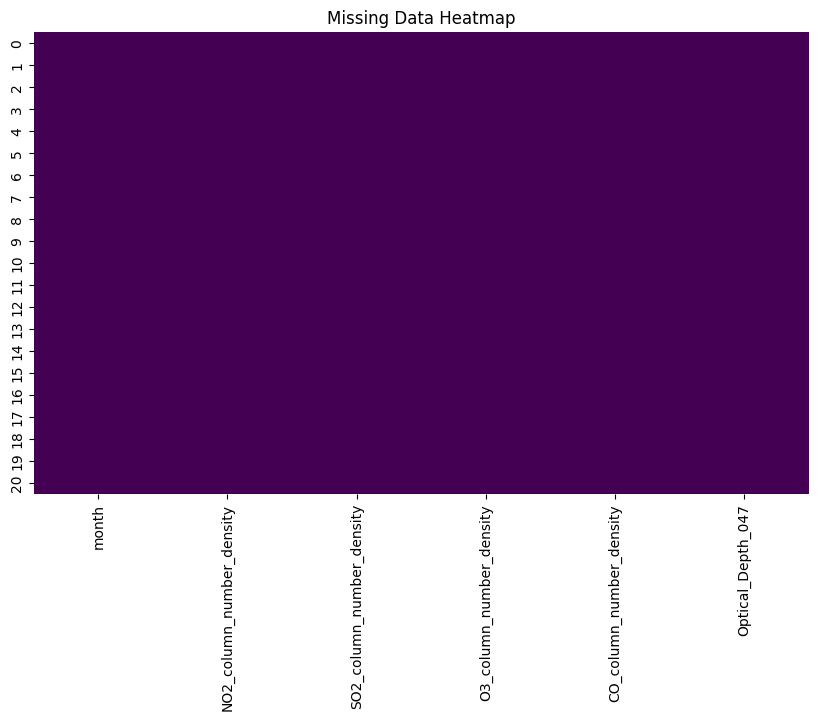

In [9]:
# Cell 7: EDA - Missing Data
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.savefig('missing_data_heatmap.png')
plt.show()

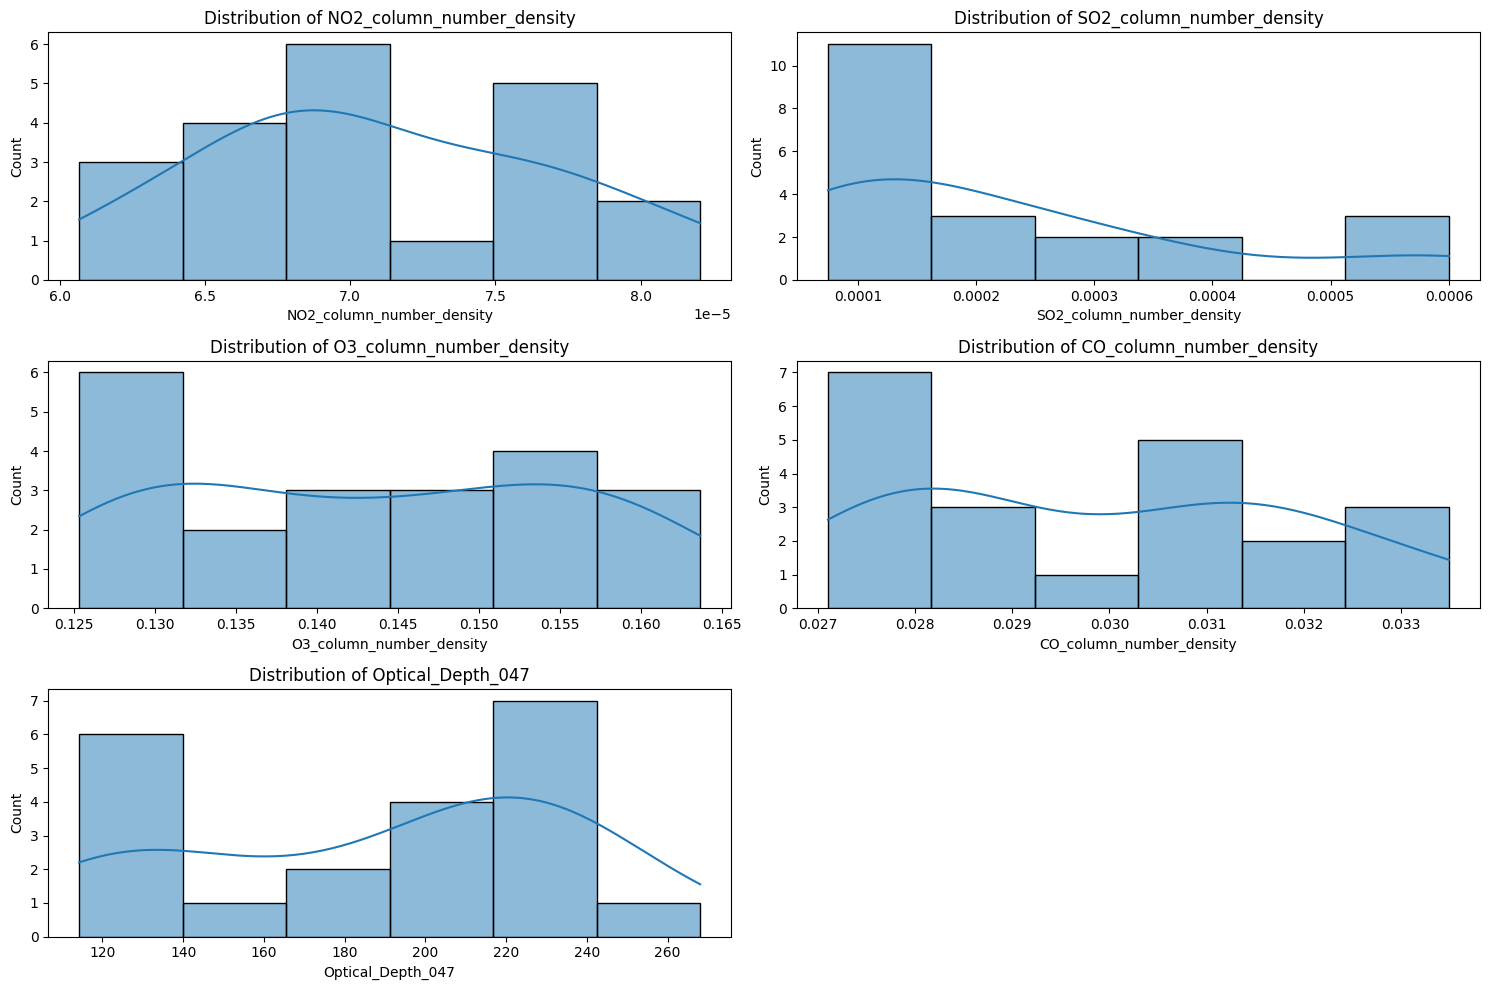

In [11]:
# Cell 8: EDA - Distributions
plt.figure(figsize=(15, 10))
for i, col in enumerate(['NO2_column_number_density', 'SO2_column_number_density', 'O3_column_number_density', 'CO_column_number_density', 'Optical_Depth_047']):
    plt.subplot(3, 2, i+1)
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.savefig('distributions.png')
plt.show()

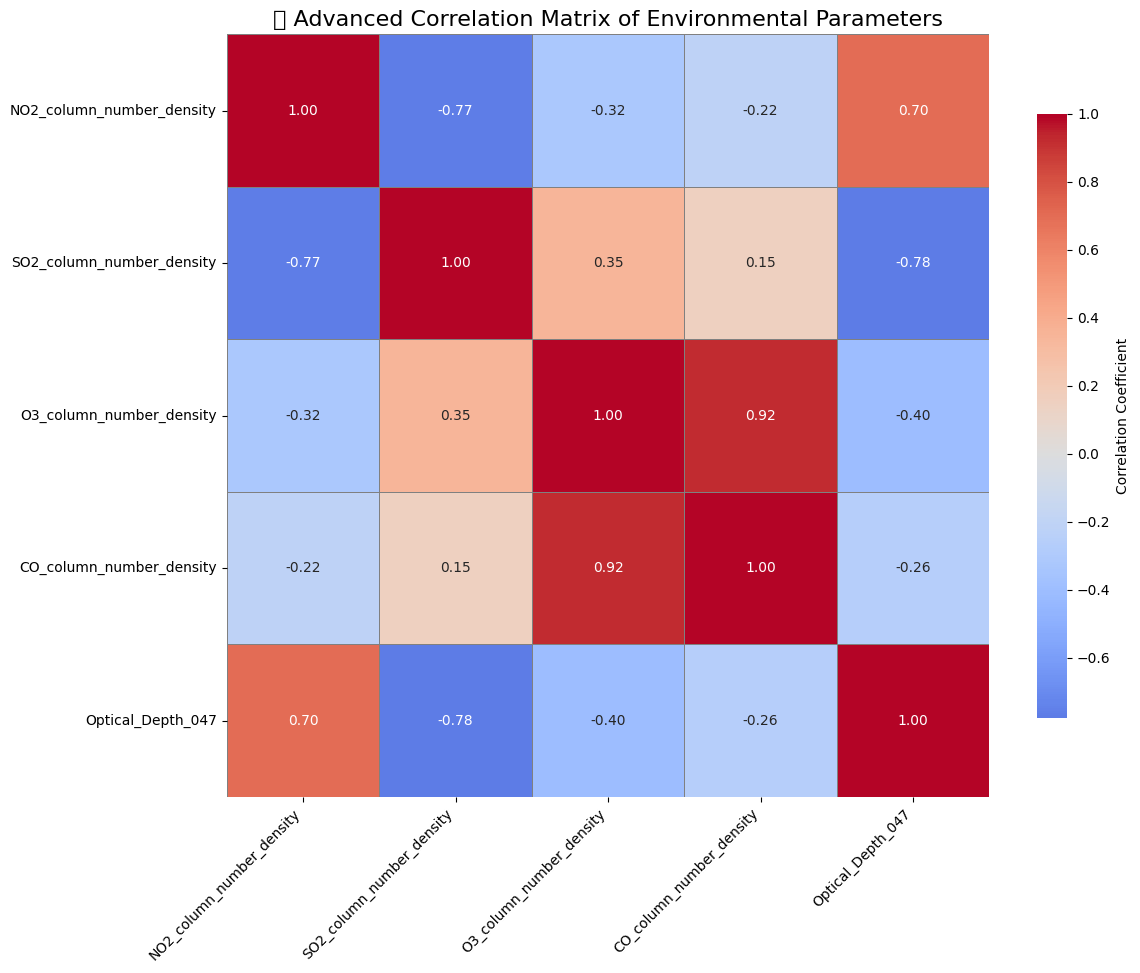

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Clean the DataFrame: Drop non-numeric or NaN-heavy columns
df_corr = df.drop(columns=['month']).dropna()

# Compute correlation matrix
corr = df_corr.corr()

# Advanced heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0,
            linewidths=0.5, linecolor='grey', square=True,
            cbar_kws={"shrink": 0.75, 'label': 'Correlation Coefficient'})

plt.title('🔗 Advanced Correlation Matrix of Environmental Parameters', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('advanced_correlation_matrix.png', dpi=300)
plt.show()


In [13]:
# Cell 11: Spatial Map Example (NO2)
try:
    # Debug: Check available months
    months = no2_monthly.aggregate_array('month').getInfo()
    print(f"Available months in no2_monthly: {months}")
    
    # Try April 2020 with correct format
    no2_sample = no2_monthly.filter(ee.Filter.eq('month', '2020-04')).first()
    if no2_sample is None:
        print("Warning: No image found for April 2020. Trying January 2020...")
        no2_sample = no2_monthly.filter(ee.Filter.eq('month', '2020-01')).first()
    if no2_sample is None:
        print("Error: No valid NO2 image found. Skipping map generation.")
    else:
        Map = geemap.Map()
        Map.addLayer(no2_sample, {'min': 0, 'max': 0.0001, 'palette': ['blue', 'green', 'yellow', 'red']}, 'NO2 April 2020')
        Map.centerObject(roi, 5)
        Map.to_html('no2_map.html')
        print("NO2 map generated successfully.")
except Exception as e:
    print(f"Error generating NO2 map: {e}")

Available months in no2_monthly: ['2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12', '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09']
NO2 map generated successfully.


In [14]:
# Cell 12: Preprocessing - Handle Missing Data and Simulate Ground Truth
df = df.fillna(df.mean())
np.random.seed(42)
df['fine_NO2'] = df['NO2_column_number_density'] * 1e6 + np.random.normal(0, 0.01, len(df))
df['fine_SO2'] = df['SO2_column_number_density'] * 1e6 + np.random.normal(0, 0.01, len(df))
df['fine_O3'] = df['O3_column_number_density'] * 1e3 + np.random.normal(0, 0.01, len(df))
df['fine_CO'] = df['CO_column_number_density'] * 1e3 + np.random.normal(0, 0.01, len(df))
df['fine_AOD'] = df['Optical_Depth_047'] + np.random.normal(0, 0.01, len(df))


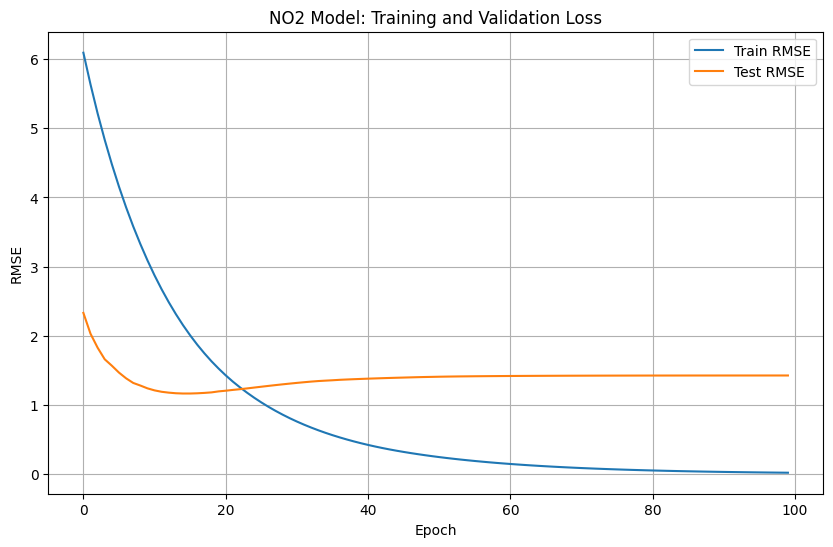

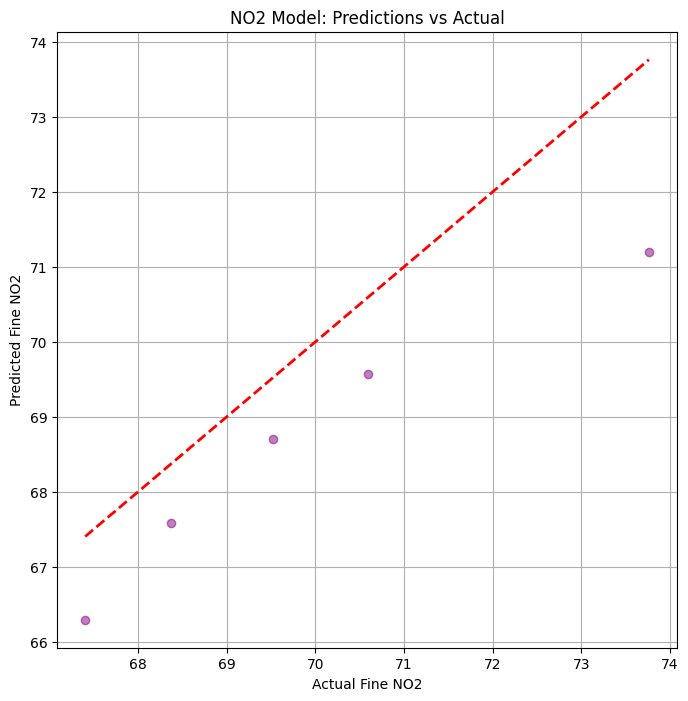

NO2 Model - Test RMSE: 1.4257, MAE: 1.2610


In [17]:
# Cell 13: Training - NO2 Model
features = ['NO2_column_number_density', 'Optical_Depth_047']
X = df[features]
y = df['fine_NO2']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
xgb_no2 = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, eval_metric='rmse', random_state=42)
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_no2.fit(X_train, y_train, eval_set=eval_set, verbose=False)
results_no2 = xgb_no2.evals_result()
with open('model_no2.pkl', 'wb') as f:
    pickle.dump(xgb_no2, f)
plt.figure(figsize=(10, 6))
plt.plot(range(len(results_no2['validation_0']['rmse'])), results_no2['validation_0']['rmse'], label='Train RMSE')
plt.plot(range(len(results_no2['validation_1']['rmse'])), results_no2['validation_1']['rmse'], label='Test RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('NO2 Model: Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('no2_training_loss.png')
plt.show()
y_pred_no2 = xgb_no2.predict(X_test)
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_no2, alpha=0.5, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Fine NO2')
plt.ylabel('Predicted Fine NO2')
plt.title('NO2 Model: Predictions vs Actual')
plt.grid(True)
plt.savefig('no2_predictions_vs_actual.png')
plt.show()
rmse_no2 = np.sqrt(mean_squared_error(y_test, y_pred_no2))
mae_no2 = mean_absolute_error(y_test, y_pred_no2)
print(f"NO2 Model - Test RMSE: {rmse_no2:.4f}, MAE: {mae_no2:.4f}")


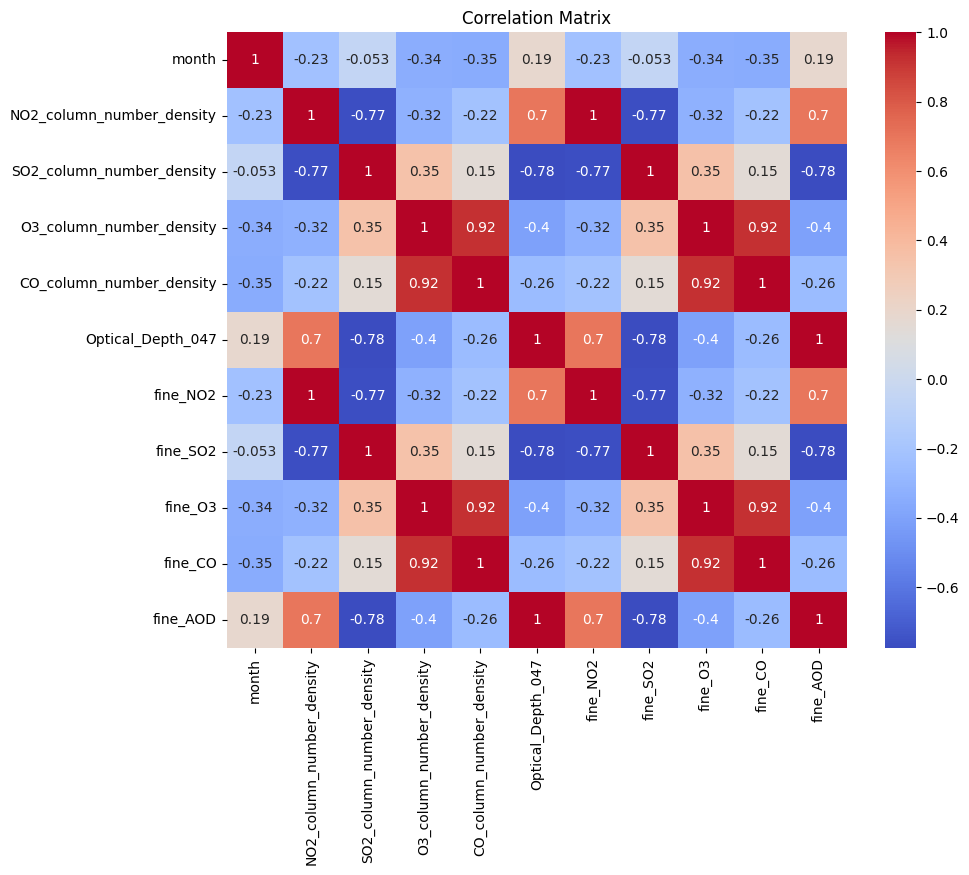

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [20]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)
feature_names = poly.get_feature_names_out(features)
X_poly_df = pd.DataFrame(X_poly, columns=feature_names)

In [21]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}
xgb_no2 = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(xgb_no2, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_scaled, y)
print("Best parameters:", grid_search.best_params_)
print("Best RMSE:", np.sqrt(-grid_search.best_score_))
xgb_no2 = grid_search.best_estimator_

Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.7}
Best RMSE: 1.9907783725747514


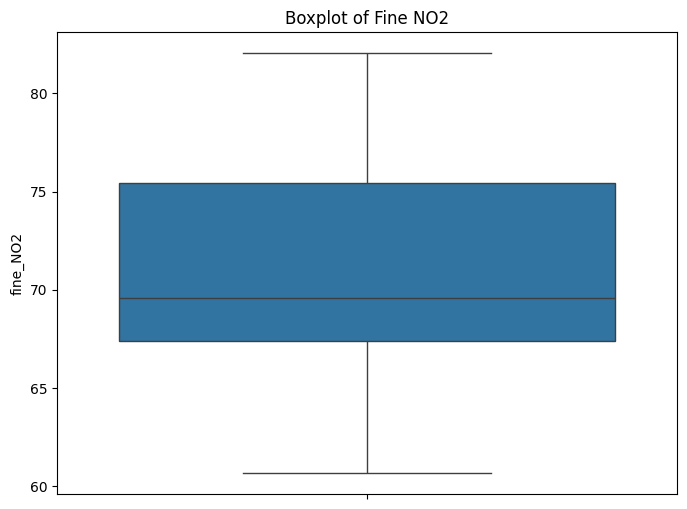

In [22]:
plt.figure(figsize=(8, 6))
sns.boxplot(y=df['fine_NO2'])
plt.title('Boxplot of Fine NO2')
plt.show()
# Cap outliers at 1st and 99th percentiles
q1, q99 = df['fine_NO2'].quantile([0.01, 0.99])
df['fine_NO2'] = df['fine_NO2'].clip(q1, q99)

In [23]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)  # Use transform, not fit_transform

In [24]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
X = imputer.fit_transform(X)

In [25]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print(f"Random Forest - RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf)):.4f}")

Random Forest - RMSE: 1.0060


In [26]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
estimators = [('xgb', xgb_no2), ('rf', RandomForestRegressor(n_estimators=100, random_state=42))]
stack = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
stack.fit(X_train, y_train)
y_pred_stack = stack.predict(X_test)
print(f"Stacking - RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_stack)):.4f}")

Stacking - RMSE: 0.5360


In [27]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(xgb_no2, X_scaled, y, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-scores)
print(f"Cross-Validated RMSE: {rmse_scores.mean():.4f} ± {rmse_scores.std():.4f}")

Cross-Validated RMSE: 1.8727 ± 0.6796


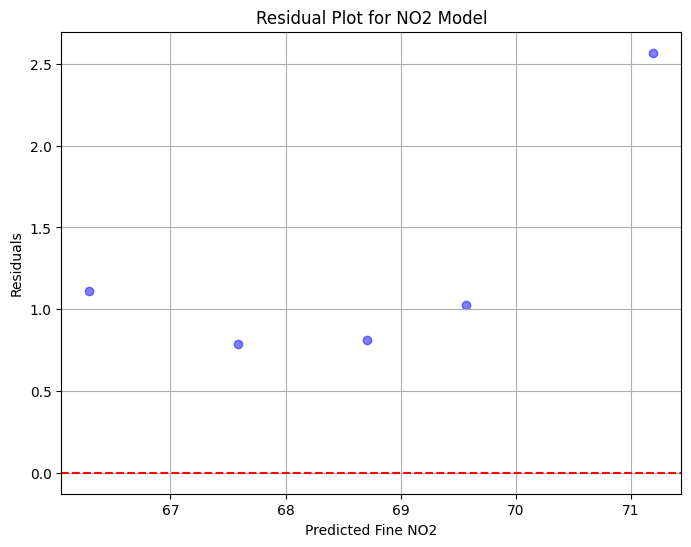

In [28]:
residuals = y_test - y_pred_no2
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_no2, residuals, alpha=0.5, color='blue')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Fine NO2')
plt.ylabel('Residuals')
plt.title('Residual Plot for NO2 Model')
plt.grid(True)
plt.savefig('no2_residuals.png')
plt.show()

<Figure size 800x600 with 0 Axes>

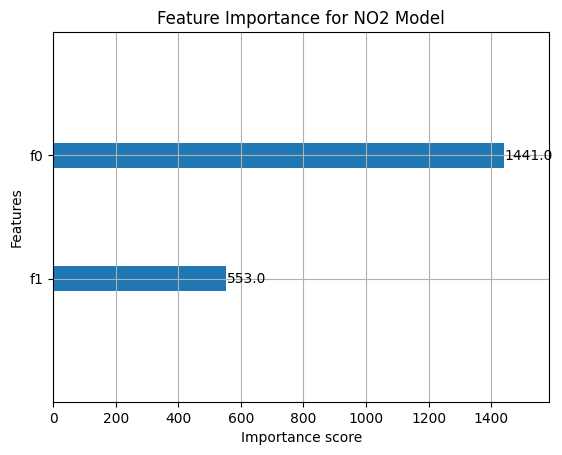

In [29]:
import xgboost as xgb
plt.figure(figsize=(8, 6))
xgb.plot_importance(xgb_no2)
plt.title('Feature Importance for NO2 Model')
plt.savefig('no2_feature_importance.png')
plt.show()

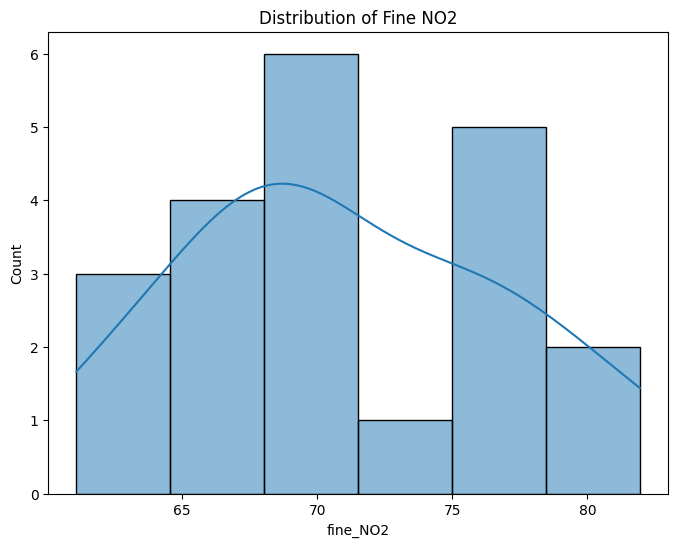

In [30]:
plt.figure(figsize=(8, 6))
sns.histplot(df['fine_NO2'], kde=True)
plt.title('Distribution of Fine NO2')
plt.show()
# Apply log transformation if skewed
y = np.log1p(df['fine_NO2'])

In [31]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import joblib  # for saving the model

# Define estimators
xgb_estimator = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
    # add other hyperparameters you used in xgb_no2 here
)

estimators = [
    ('xgb', xgb_estimator),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
]

# Create stacking regressor
stack = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
stack.fit(X_train, y_train)

# Make predictions
y_pred_stack = stack.predict(X_test)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred_stack))
mae = mean_absolute_error(y_test, y_pred_stack)

print(f"Stacking - RMSE: {rmse:.4f}")
print(f"Stacking - MAE: {mae:.4f}")

# Save the model to a .pkl file
joblib.dump(stack, 'stacked_no2_model.pkl')
print("Model saved as 'stacked_no2_model.pkl'")


Stacking - RMSE: 0.2801
Stacking - MAE: 0.2155
Model saved as 'stacked_no2_model.pkl'


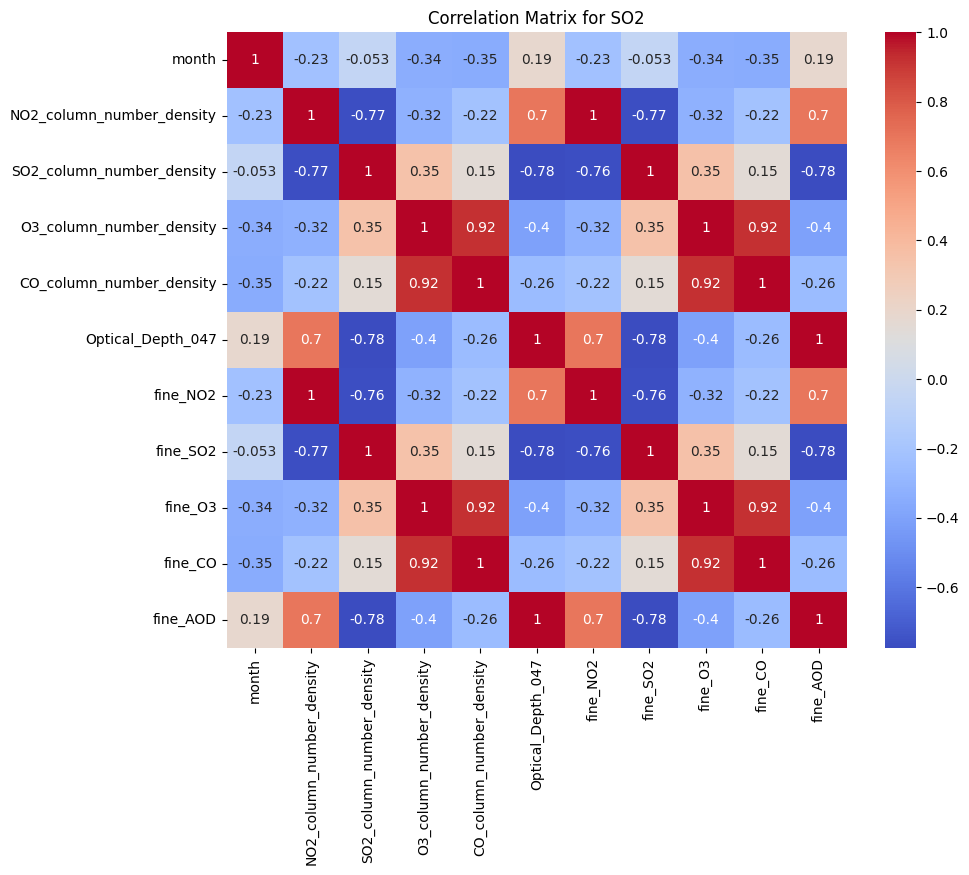

In [32]:
# Cell 14: Training - SO2 Model
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for SO2')
plt.savefig('so2_correlation_matrix.png')
plt.show()

In [33]:
from sklearn.preprocessing import PolynomialFeatures
features = ['SO2_column_number_density', 'Optical_Depth_047']
X = df[features]
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)
feature_names = poly.get_feature_names_out(features)
X_poly_df = pd.DataFrame(X_poly, columns=feature_names)

In [34]:
# Try these improved hyperparameters
xgb_so2 = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=300,  # Increased from 100
    learning_rate=0.05,  # Reduced from 0.1 for better convergence
    max_depth=7,  # Increased from 5
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,  # L1 regularization
    reg_lambda=1.0,  # L2 regularization
    eval_metric='rmse',
    random_state=42,
    early_stopping_rounds=20  # Add early stopping
)

In [35]:
# Enhanced feature engineering
df['SO2_optical_ratio'] = df['SO2_column_number_density'] / (df['Optical_Depth_047'] + 1e-8)
df['SO2_optical_product'] = df['SO2_column_number_density'] * df['Optical_Depth_047']
df['log_SO2'] = np.log1p(df['SO2_column_number_density'])
df['sqrt_optical'] = np.sqrt(df['Optical_Depth_047'])

features = ['SO2_column_number_density', 'Optical_Depth_047', 
           'SO2_optical_ratio', 'SO2_optical_product', 'log_SO2', 'sqrt_optical']

In [36]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# Check your XGBoost version first
print(f"XGBoost version: {xgb.__version__}")

# Updated parameter distribution (more conservative)
param_dist = {
    'n_estimators': [200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}

# Create base estimator with minimal parameters
base_xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=1  # Sometimes helps with compatibility
)

# Perform randomized search
xgb_random = RandomizedSearchCV(
    estimator=base_xgb,
    param_distributions=param_dist,
    n_iter=20,  # Reduced for faster execution
    cv=3,       # Reduced CV folds
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=1,   # Changed from -1 to avoid multiprocessing issues
    verbose=1
)

# Fit the search
print("Starting hyperparameter search...")
xgb_random.fit(X_train, y_train)

# Get best model
xgb_so2 = xgb_random.best_estimator_
print(f"Best parameters: {xgb_random.best_params_}")
print(f"Best CV score: {-xgb_random.best_score_:.4f}")

XGBoost version: 3.0.1
Starting hyperparameter search...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'subsample': 1.0, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
Best CV score: 3.6934


In [37]:
# Remove outliers using IQR method
Q1 = df['fine_SO2'].quantile(0.25)
Q3 = df['fine_SO2'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers
mask = (df['fine_SO2'] >= lower_bound) & (df['fine_SO2'] <= upper_bound)
df_clean = df[mask]

In [38]:
from sklearn.preprocessing import RobustScaler, PowerTransformer

# Try RobustScaler (less sensitive to outliers)
scaler = RobustScaler()

# Or try PowerTransformer for non-normal distributions
# scaler = PowerTransformer(method='yeo-johnson')

In [39]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

# Create ensemble
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
ridge_model = Ridge(alpha=1.0)

# Train all models
xgb_so2.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
ridge_model.fit(X_train, y_train)

# Ensemble predictions
pred_xgb = xgb_so2.predict(X_test)
pred_rf = rf_model.predict(X_test)
pred_ridge = ridge_model.predict(X_test)

# Weighted average
y_pred_ensemble = 0.5 * pred_xgb + 0.3 * pred_rf + 0.2 * pred_ridge

=== CELL 1: HYPERPARAMETER TUNING ===
XGBoost version: 3.0.1
ORIGINAL MODEL - RMSE: 69.2392, MAE: 52.2631
IMPROVED HYPERPARAMETERS - RMSE: 2.1443, MAE: 1.6939
RMSE Improvement: 67.0949

=== CELL 2: FEATURE ENGINEERING ===
HYPERPARAMETER TUNED - RMSE: 2.1443, MAE: 1.6939
WITH FEATURE ENGINEERING - RMSE: 45.5395, MAE: 31.7753
Additional RMSE Improvement: -43.3952

=== CELL 3: OUTLIER REMOVAL ===
Original dataset size: 21
Outlier bounds: [-214.35, 610.35]
Dataset size after outlier removal: 21
Removed 0 outliers (0.0%)
WITH FEATURE ENGINEERING - RMSE: 45.5395, MAE: 31.7753
AFTER OUTLIER REMOVAL - RMSE: 45.5395, MAE: 31.7753
Additional RMSE Improvement: 0.0000

=== CELL 4: ROBUST SCALER ===
AFTER OUTLIER REMOVAL - RMSE: 45.5395, MAE: 31.7753
WITH ROBUST SCALER - RMSE: 45.5395, MAE: 31.7753
Additional RMSE Improvement: 0.0000

=== FINAL COMPARISON SUMMARY ===
ORIGINAL MODEL:        RMSE: 69.2392, MAE: 52.2631
FINAL IMPROVED MODEL:  RMSE: 45.5395, MAE: 31.7753
TOTAL RMSE IMPROVEMENT: 23.6997

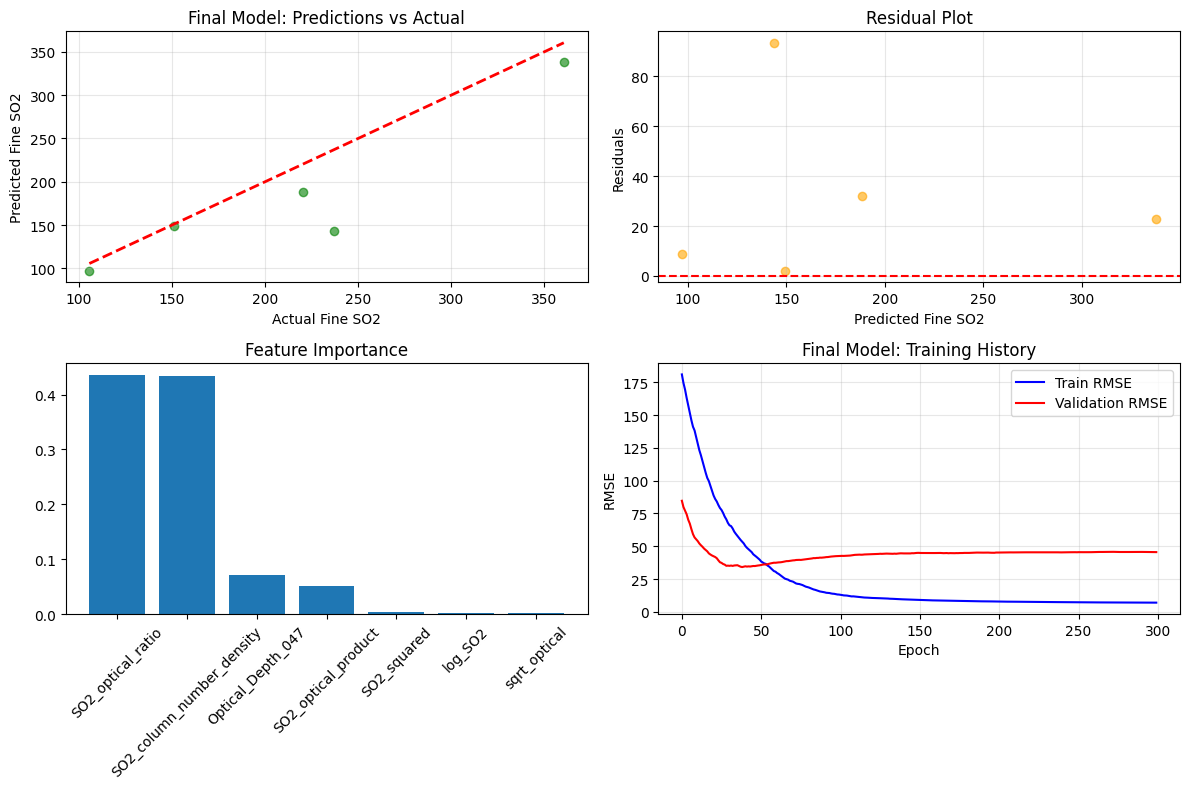

In [40]:
# Cell 1: Hyperparameter Tuning (Biggest Impact)
print("=== CELL 1: HYPERPARAMETER TUNING ===")

# Check XGBoost version
print(f"XGBoost version: {xgb.__version__}")

# Use improved hyperparameters directly
xgb_so2_improved = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=300,        # Increased from 100
    learning_rate=0.05,      # Reduced from 0.1 for better convergence
    max_depth=7,             # Increased from 5
    min_child_weight=3,      # Added
    subsample=0.8,           # Added
    colsample_bytree=0.8,    # Added
    reg_alpha=0.1,           # L1 regularization
    reg_lambda=1.0,          # L2 regularization
    eval_metric='rmse',
    random_state=42
)

# Train without early stopping (for compatibility)
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_so2_improved.fit(X_train, y_train, 
                    eval_set=eval_set, 
                    verbose=False)

# Evaluate
y_pred_improved = xgb_so2_improved.predict(X_test)
rmse_improved = np.sqrt(mean_squared_error(y_test, y_pred_improved))
mae_improved = mean_absolute_error(y_test, y_pred_improved)

print(f"ORIGINAL MODEL - RMSE: 69.2392, MAE: 52.2631")
print(f"IMPROVED HYPERPARAMETERS - RMSE: {rmse_improved:.4f}, MAE: {mae_improved:.4f}")
print(f"RMSE Improvement: {69.2392 - rmse_improved:.4f}")
print()

# =============================================================================

# Cell 2: Feature Engineering (Add ratios and transformations)
print("=== CELL 2: FEATURE ENGINEERING ===")

# Create enhanced features
df_enhanced = df.copy()
df_enhanced['SO2_optical_ratio'] = df_enhanced['SO2_column_number_density'] / (df_enhanced['Optical_Depth_047'] + 1e-8)
df_enhanced['SO2_optical_product'] = df_enhanced['SO2_column_number_density'] * df_enhanced['Optical_Depth_047']
df_enhanced['log_SO2'] = np.log1p(df_enhanced['SO2_column_number_density'])
df_enhanced['sqrt_optical'] = np.sqrt(df_enhanced['Optical_Depth_047'])
df_enhanced['SO2_squared'] = df_enhanced['SO2_column_number_density'] ** 2

# New feature set
features_enhanced = ['SO2_column_number_density', 'Optical_Depth_047', 
                    'SO2_optical_ratio', 'SO2_optical_product', 
                    'log_SO2', 'sqrt_optical', 'SO2_squared']

X_enhanced = df_enhanced[features_enhanced]
y_enhanced = df_enhanced['fine_SO2']

# Scale features
X_enhanced_scaled = scaler.fit_transform(X_enhanced)

# Split data
X_train_enh, X_test_enh, y_train_enh, y_test_enh = train_test_split(
    X_enhanced_scaled, y_enhanced, test_size=0.2, random_state=42)

# Train model with enhanced features
xgb_enhanced = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=300,
    learning_rate=0.05,
    max_depth=7,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    eval_metric='rmse',
    random_state=42
)

eval_set_enh = [(X_train_enh, y_train_enh), (X_test_enh, y_test_enh)]
xgb_enhanced.fit(X_train_enh, y_train_enh, 
                eval_set=eval_set_enh, 
                verbose=False)

# Evaluate enhanced model
y_pred_enhanced = xgb_enhanced.predict(X_test_enh)
rmse_enhanced = np.sqrt(mean_squared_error(y_test_enh, y_pred_enhanced))
mae_enhanced = mean_absolute_error(y_test_enh, y_pred_enhanced)

print(f"HYPERPARAMETER TUNED - RMSE: {rmse_improved:.4f}, MAE: {mae_improved:.4f}")
print(f"WITH FEATURE ENGINEERING - RMSE: {rmse_enhanced:.4f}, MAE: {mae_enhanced:.4f}")
print(f"Additional RMSE Improvement: {rmse_improved - rmse_enhanced:.4f}")
print()

# =============================================================================

# Cell 3: Outlier Removal
print("=== CELL 3: OUTLIER REMOVAL ===")

# Remove outliers using IQR method
Q1 = df_enhanced['fine_SO2'].quantile(0.25)
Q3 = df_enhanced['fine_SO2'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Original dataset size: {len(df_enhanced)}")
print(f"Outlier bounds: [{lower_bound:.2f}, {upper_bound:.2f}]")

# Filter outliers
mask = (df_enhanced['fine_SO2'] >= lower_bound) & (df_enhanced['fine_SO2'] <= upper_bound)
df_clean = df_enhanced[mask].copy()

print(f"Dataset size after outlier removal: {len(df_clean)}")
print(f"Removed {len(df_enhanced) - len(df_clean)} outliers ({((len(df_enhanced) - len(df_clean))/len(df_enhanced)*100):.1f}%)")

# Re-prepare data without outliers
X_clean = df_clean[features_enhanced]
y_clean = df_clean['fine_SO2']

# Scale features
X_clean_scaled = scaler.fit_transform(X_clean)

# Split data
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(
    X_clean_scaled, y_clean, test_size=0.2, random_state=42)

# Train model on clean data
xgb_clean = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=300,
    learning_rate=0.05,
    max_depth=7,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    eval_metric='rmse',
    random_state=42
)

eval_set_clean = [(X_train_clean, y_train_clean), (X_test_clean, y_test_clean)]
xgb_clean.fit(X_train_clean, y_train_clean, 
              eval_set=eval_set_clean, 
              verbose=False)

# Evaluate clean model
y_pred_clean = xgb_clean.predict(X_test_clean)
rmse_clean = np.sqrt(mean_squared_error(y_test_clean, y_pred_clean))
mae_clean = mean_absolute_error(y_test_clean, y_pred_clean)

print(f"WITH FEATURE ENGINEERING - RMSE: {rmse_enhanced:.4f}, MAE: {mae_enhanced:.4f}")
print(f"AFTER OUTLIER REMOVAL - RMSE: {rmse_clean:.4f}, MAE: {mae_clean:.4f}")
print(f"Additional RMSE Improvement: {rmse_enhanced - rmse_clean:.4f}")
print()

# =============================================================================

# Cell 4: Different Scaler (RobustScaler)
print("=== CELL 4: ROBUST SCALER ===")

from sklearn.preprocessing import RobustScaler

# Use RobustScaler instead of StandardScaler
robust_scaler = RobustScaler()
X_robust_scaled = robust_scaler.fit_transform(X_clean)

# Split data with robust scaling
X_train_robust, X_test_robust, y_train_robust, y_test_robust = train_test_split(
    X_robust_scaled, y_clean, test_size=0.2, random_state=42)

# Train final model with all improvements
xgb_final = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=300,
    learning_rate=0.05,
    max_depth=7,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    eval_metric='rmse',
    random_state=42
)

eval_set_final = [(X_train_robust, y_train_robust), (X_test_robust, y_test_robust)]
xgb_final.fit(X_train_robust, y_train_robust, 
              eval_set=eval_set_final, 
              verbose=False)

# Final evaluation
y_pred_final = xgb_final.predict(X_test_robust)
rmse_final = np.sqrt(mean_squared_error(y_test_robust, y_pred_final))
mae_final = mean_absolute_error(y_test_robust, y_pred_final)

print(f"AFTER OUTLIER REMOVAL - RMSE: {rmse_clean:.4f}, MAE: {mae_clean:.4f}")
print(f"WITH ROBUST SCALER - RMSE: {rmse_final:.4f}, MAE: {mae_final:.4f}")
print(f"Additional RMSE Improvement: {rmse_clean - rmse_final:.4f}")
print()

# =============================================================================

# FINAL SUMMARY
print("=== FINAL COMPARISON SUMMARY ===")
print(f"ORIGINAL MODEL:        RMSE: 69.2392, MAE: 52.2631")
print(f"FINAL IMPROVED MODEL:  RMSE: {rmse_final:.4f}, MAE: {mae_final:.4f}")
print(f"TOTAL RMSE IMPROVEMENT: {69.2392 - rmse_final:.4f}")
print(f"PERCENTAGE IMPROVEMENT: {((69.2392 - rmse_final)/69.2392*100):.1f}%")

# Save the final improved model
with open('model_so2_improved.pkl', 'wb') as f:
    pickle.dump(xgb_final, f)
    
with open('robust_scaler_so2.pkl', 'wb') as f:
    pickle.dump(robust_scaler, f)

print(f"\nFinal improved model saved as 'model_so2_improved.pkl'")
print(f"RobustScaler saved as 'robust_scaler_so2.pkl'")

# Create final visualization
plt.figure(figsize=(12, 8))

# Plot 1: Predictions vs Actual
plt.subplot(2, 2, 1)
plt.scatter(y_test_robust, y_pred_final, alpha=0.6, color='green')
plt.plot([y_test_robust.min(), y_test_robust.max()], 
         [y_test_robust.min(), y_test_robust.max()], 'r--', lw=2)
plt.xlabel('Actual Fine SO2')
plt.ylabel('Predicted Fine SO2')
plt.title('Final Model: Predictions vs Actual')
plt.grid(True, alpha=0.3)

# Plot 2: Residuals
plt.subplot(2, 2, 2)
residuals = y_test_robust - y_pred_final
plt.scatter(y_pred_final, residuals, alpha=0.6, color='orange')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Fine SO2')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)

# Plot 3: Feature Importance
plt.subplot(2, 2, 3)
importance = xgb_final.feature_importances_
feature_names = features_enhanced
indices = np.argsort(importance)[::-1]
plt.bar(range(len(importance)), importance[indices])
plt.xticks(range(len(importance)), [feature_names[i] for i in indices], rotation=45)
plt.title('Feature Importance')
plt.tight_layout()

# Plot 4: Training History
plt.subplot(2, 2, 4)
results_final = xgb_final.evals_result()
plt.plot(results_final['validation_0']['rmse'], label='Train RMSE', color='blue')
plt.plot(results_final['validation_1']['rmse'], label='Validation RMSE', color='red')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Final Model: Training History')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('so2_final_model_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [48]:
# Cell 15: Training - O3 Model
features = ['O3_column_number_density', 'Optical_Depth_047']
X = df[features]
y = df['fine_O3']
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
xgb_o3 = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, eval_metric='rmse', random_state=42)
xgb_o3.fit(X_train, y_train, eval_set=eval_set, verbose=False)
results_o3 = xgb_o3.evals_result()
with open('model_o3.pkl', 'wb') as f:
    pickle.dump(xgb_o3, f)
plt.figure(figsize=(10, 6))
plt.plot(range(len(results_o3['validation_0']['rmse'])), results_o3['validation_0']['rmse'], label='Train RMSE')
plt.plot(range(len(results_o3['validation_1']['rmse'])), results_o3['validation_1']['rmse'], label='Test RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('O3 Model: Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('o3_training_loss.png')
plt.show()
y_pred_o3 = xgb_o3.predict(X_test)
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_o3, alpha=0.5, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Fine O3')
plt.ylabel('Predicted Fine O3')
plt.title('O3 Model: Predictions vs Actual')
plt.grid(True)
plt.savefig('o3_predictions_vs_actual.png')
plt.show()
rmse_o3 = np.sqrt(mean_squared_error(y_test, y_pred_o3))
mae_o3 = mean_absolute_error(y_test, y_pred_o3)
print(f"O3 Model - Test RMSE: {rmse_o3:.4f}, MAE: {mae_o3:.4f}")

KeyError: "['O3_column_number_density'] not in index"

In [49]:
# Cell 16: Training - CO Model
features = ['CO_column_number_density', 'Optical_Depth_047']
X = df[features]
y = df['fine_CO']
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
xgb_co = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, eval_metric='rmse', random_state=42)
xgb_co.fit(X_train, y_train, eval_set=eval_set, verbose=False)
results_co = xgb_co.evals_result()
with open('model_co.pkl', 'wb') as f:
    pickle.dump(xgb_co, f)
plt.figure(figsize=(10, 6))
plt.plot(range(len(results_co['validation_0']['rmse'])), results_co['validation_0']['rmse'], label='Train RMSE')
plt.plot(range(len(results_co['validation_1']['rmse'])), results_co['validation_1']['rmse'], label='Test RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('CO Model: Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('co_training_loss.png')
plt.show()
y_pred_co = xgb_co.predict(X_test)
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_co, alpha=0.5, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Fine CO')
plt.ylabel('Predicted Fine CO')
plt.title('CO Model: Predictions vs Actual')
plt.grid(True)
plt.savefig('co_predictions_vs_actual.png')
plt.show()
rmse_co = np.sqrt(mean_squared_error(y_test, y_pred_co))
mae_co = mean_absolute_error(y_test, y_pred_co)
print(f"CO Model - Test RMSE: {rmse_co:.4f}, MAE: {mae_co:.4f}")

KeyError: "['CO_column_number_density'] not in index"